# Создание модели расчета основных параметров ТЭЦ

Теплоэлектроцентраль (ТЭЦ) — разновидность тепловой электростанции, которая не только производит электроэнергию, но и является источником тепловой энергии в централизованных системах теплоснабжения (в виде пара и горячей воды, в том числе и для обеспечения горячего водоснабжения и отопления жилых и промышленных объектов).

Изучение работы ТЭЦ представляет собой одну из самых сложных задач, поскольку работа ТЭЦ представляет собой сложную структуру с множеством процессов, тепловых циклов, которые влияют на КПД и экономический доход.

Данная работа проводится на основании данных от одной из ТЭЦ России. Цель работы:

Найти основные закономерности, влияющие на выработку энергоресурсов от ТЭЦ.
- Построить модель, прогнозирующую отпуск тепла через основные показатели тепла.
- Построить модель, прогнозирующую отпуск тепла по общим характеристикам ТЭЦ.
- Построить модель, прогнозирующую расход газа относительно выработки электроэнергии и тепла.
- Построить модель, прогнозирующую расход тепла относительно выработки электроэнергии и расхода газа.
- Построить модель, прогнозирующую выработку электроэнергии относительно расхода тепла и расхода газа.

Дано:
Архив данных с 2010 года по 2024 год, включающий в себя отпуск тепла по 2 магистралям одной из ТЭЦ, параметры магистралей, температура наружного воздуха и температура окружающей среды.
Второй датасете содержатся данные по выработке электроэнергии и затраченному топливу.
Третий датасет содержит цены на ресурсы за этот же период.

В связи с NDA, я не буду использовать полное описание данных, которые использую в работе. Также данные будут изменены в определенном формате для не расскрытия информации. В контексте конфиденциальности, я не раскрываю конкретную информацию о ТЭЦ.

In [1]:
# pip install tensorflow
# pip install xgboost
# pip install catboost
# pip install hyperopt
# pip install space_eval

In [2]:
# Импорт библиотек
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from catboost import CatBoostRegressor
from hyperopt import hp, tpe, Trials, fmin, space_eval

In [71]:
%whos

Variable                    Type                 Data/Info
----------------------------------------------------------
CatBoostRegressor           type                 <class 'catboost.core.CatBoostRegressor'>
ColumnTransformer           ABCMeta              <class 'sklearn.compose._<...>ormer.ColumnTransformer'>
DecisionTreeRegressor       ABCMeta              <class 'sklearn.tree._cla<...>s.DecisionTreeRegressor'>
Dense                       type                 <class 'keras.src.layers.core.dense.Dense'>
GradientBoostingRegressor   ABCMeta              <class 'sklearn.ensemble.<...>adientBoostingRegressor'>
GridSearchCV                ABCMeta              <class 'sklearn.model_sel<...>on._search.GridSearchCV'>
LinearRegression            ABCMeta              <class 'sklearn.linear_mo<...>._base.LinearRegression'>
OneHotEncoder               type                 <class 'sklearn.preproces<...>_encoders.OneHotEncoder'>
Pipeline                    ABCMeta              <class 'sklearn.pip

## 1 Предобработка данных

### 1.1 Датасет с отпуском тепла по магистралям

In [3]:
# выгрузка датасета
df = pd.read_excel('thermal power station.xlsx')

In [4]:
# функция для вывода информации по таблице и проверки на явные дубликаты
def df_main_info(df):
    display(df.head(3), df.info())
    display('Кол-во явных дубликатов: ', df.duplicated().sum())

In [5]:
df_main_info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4960 entries, 0 to 4959
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     4960 non-null   datetime64[ns]
 1   v М1     4960 non-null   int64         
 2   v М2     4960 non-null   int64         
 3   v Q      4960 non-null   int64         
 4   v T1     4960 non-null   object        
 5   v T2     4960 non-null   object        
 6   n М1     4960 non-null   int64         
 7   n М2     4960 non-null   int64         
 8   n Q      4960 non-null   int64         
 9   n t1     4960 non-null   object        
 10  n t2     4960 non-null   object        
 11  tnv      4960 non-null   float64       
 12  th_v     4960 non-null   float64       
 13  steam t  4960 non-null   float64       
 14  steam Q  4960 non-null   float64       
 15  sum_M1   4960 non-null   int64         
 16  sum_M2   4960 non-null   int64         
 17  avg_T1   4865 non-null   float64 

,date,v М1,v М2,v Q,v T1,v T2,n М1,n М2,n Q,n t1,n t2,tnv,th_v,steam t,steam Q,sum_M1,sum_M2,avg_T1,avg_T2,sum_q
0,2010-09-01,26198,16051,658,73.59,69.57,32784,21152,819,73.58,69.57,12.3,15.29,40.0,27.0,58982,37203,73.584442,69.57,1504.0
1,2010-09-02,27299,16564,694,73.55,69.59,33304,21786,816,73.53,69.59,10.4,15.30,23.0,16.0,60603,38350,73.539009,69.59,1526.0
2,2010-09-03,28203,17755,698,74.2,69.7,33258,22489,803,74.19,69.7,10.6,15.26,28.0,19.0,61461,40244,74.194589,69.70,1520.0


None

'Кол-во явных дубликатов: '

0

In [6]:
# проверка дубликатов
def pass_value_barh(df):
    try:
        (
            (df.isna().mean()*100)
            .to_frame()
            .rename(columns = {0:'space'})
            .query('space > 0')
            .sort_values(by = 'space', ascending = True)
            .plot(kind = 'barh', figsize = (25,10), rot = 0, legend = False, fontsize = 16)
            .set_title('Пропуски по столбцам' + "\n", fontsize = 22, color = 'SteelBlue')
        );
    except:
        print('пропусков не осталось :) или произошла ошибка в первой части функции ')

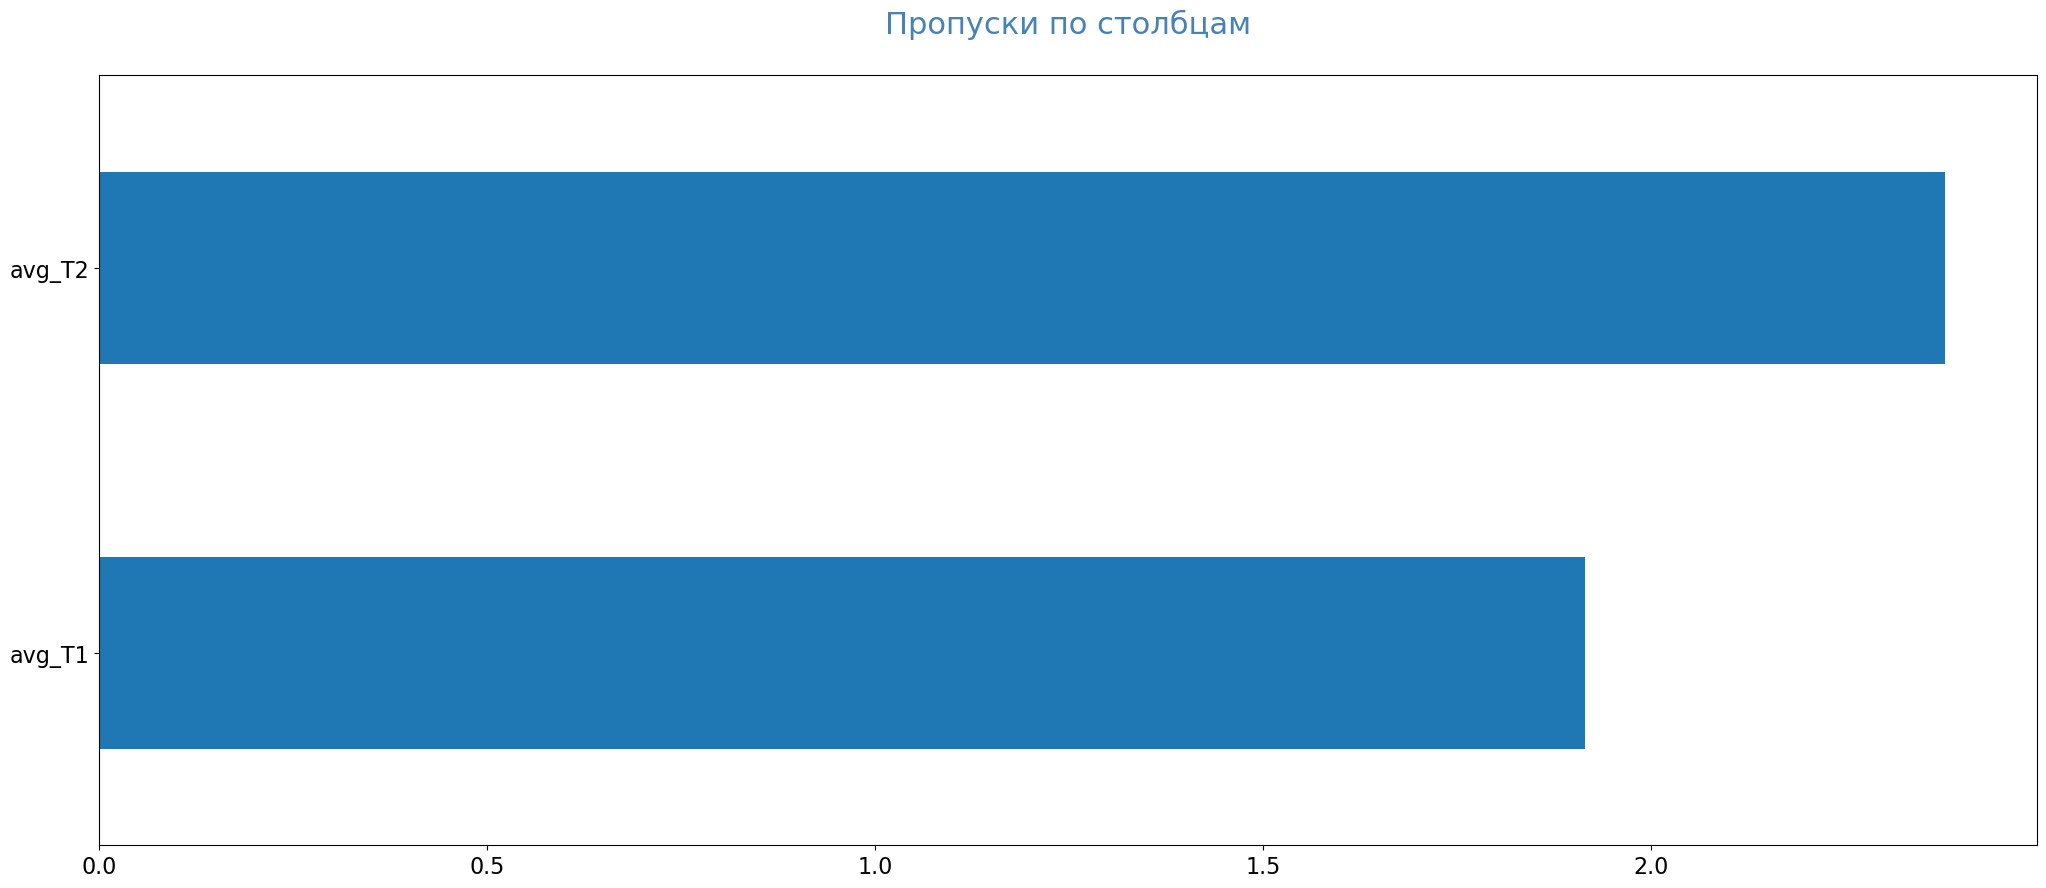

In [7]:
pass_value_barh(df)

In [8]:
# Заполняем пропуски нулями
df = df.fillna(0)
# Привести значения columns к нижнему регистру
df.columns = df.columns.str.lower()

In [9]:
list_float = ['v t1','v t2','n t1','n t2']

df[list_float] = df[list_float].applymap(lambda x: x.replace(',', '.') 
                                         if isinstance(x, str) and ',' in x else x).astype(float)

### 1.2 Датасет с основными техническими характеристиками

In [10]:
# выгрузка датасета
elen = pd.read_excel('import.xlsx')

In [11]:
df_main_info(elen)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5204 entries, 0 to 5203
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   date                5204 non-null   datetime64[ns]
 1   tn_v                5197 non-null   float64       
 2   thv                 5197 non-null   float64       
 3   p_barom             5197 non-null   float64       
 4   pl_gaza             5197 non-null   float64       
 5   kal_gaza            5197 non-null   float64       
 6   rashod_gaza         5197 non-null   float64       
 7   rashod_gaza_tyt     5197 non-null   float64       
 8   par_potr_t          5197 non-null   float64       
 9   vozr_cond_t         5197 non-null   float64       
 10  nevozr_cond_t       5197 non-null   float64       
 11  hov_t               5197 non-null   float64       
 12  poteri_para_kond_t  5197 non-null   float64       
 13  poteri_para_kond_%  5197 non-null   float64     

,date,tn_v,thv,p_barom,pl_gaza,kal_gaza,rashod_gaza,rashod_gaza_tyt,par_potr_t,vozr_cond_t,nevozr_cond_t,hov_t,poteri_para_kond_t,poteri_para_kond_%,v_elen_mvtch,cn_elen_mvtch,o_elen_mvtch,vsego_tyt
0,2010-01-01,-13.9,0.0,754.4,0.68,8014.0,1959.390,2243.0,329.0,0.0,329.0,998.0,669.0,3.39,3249.096,371.719,2877.377,2243.0
1,2010-01-02,-15.2,0.0,759.2,0.68,8017.0,1937.367,2219.0,329.0,0.0,329.0,1132.0,803.0,4.09,3266.779,367.598,2899.181,2219.0
2,2010-01-03,-16.3,0.0,758.7,0.68,8020.0,1981.099,2270.0,331.0,0.0,331.0,919.0,588.0,3.00,3230.462,370.319,2860.143,2270.0


None

'Кол-во явных дубликатов: '

0

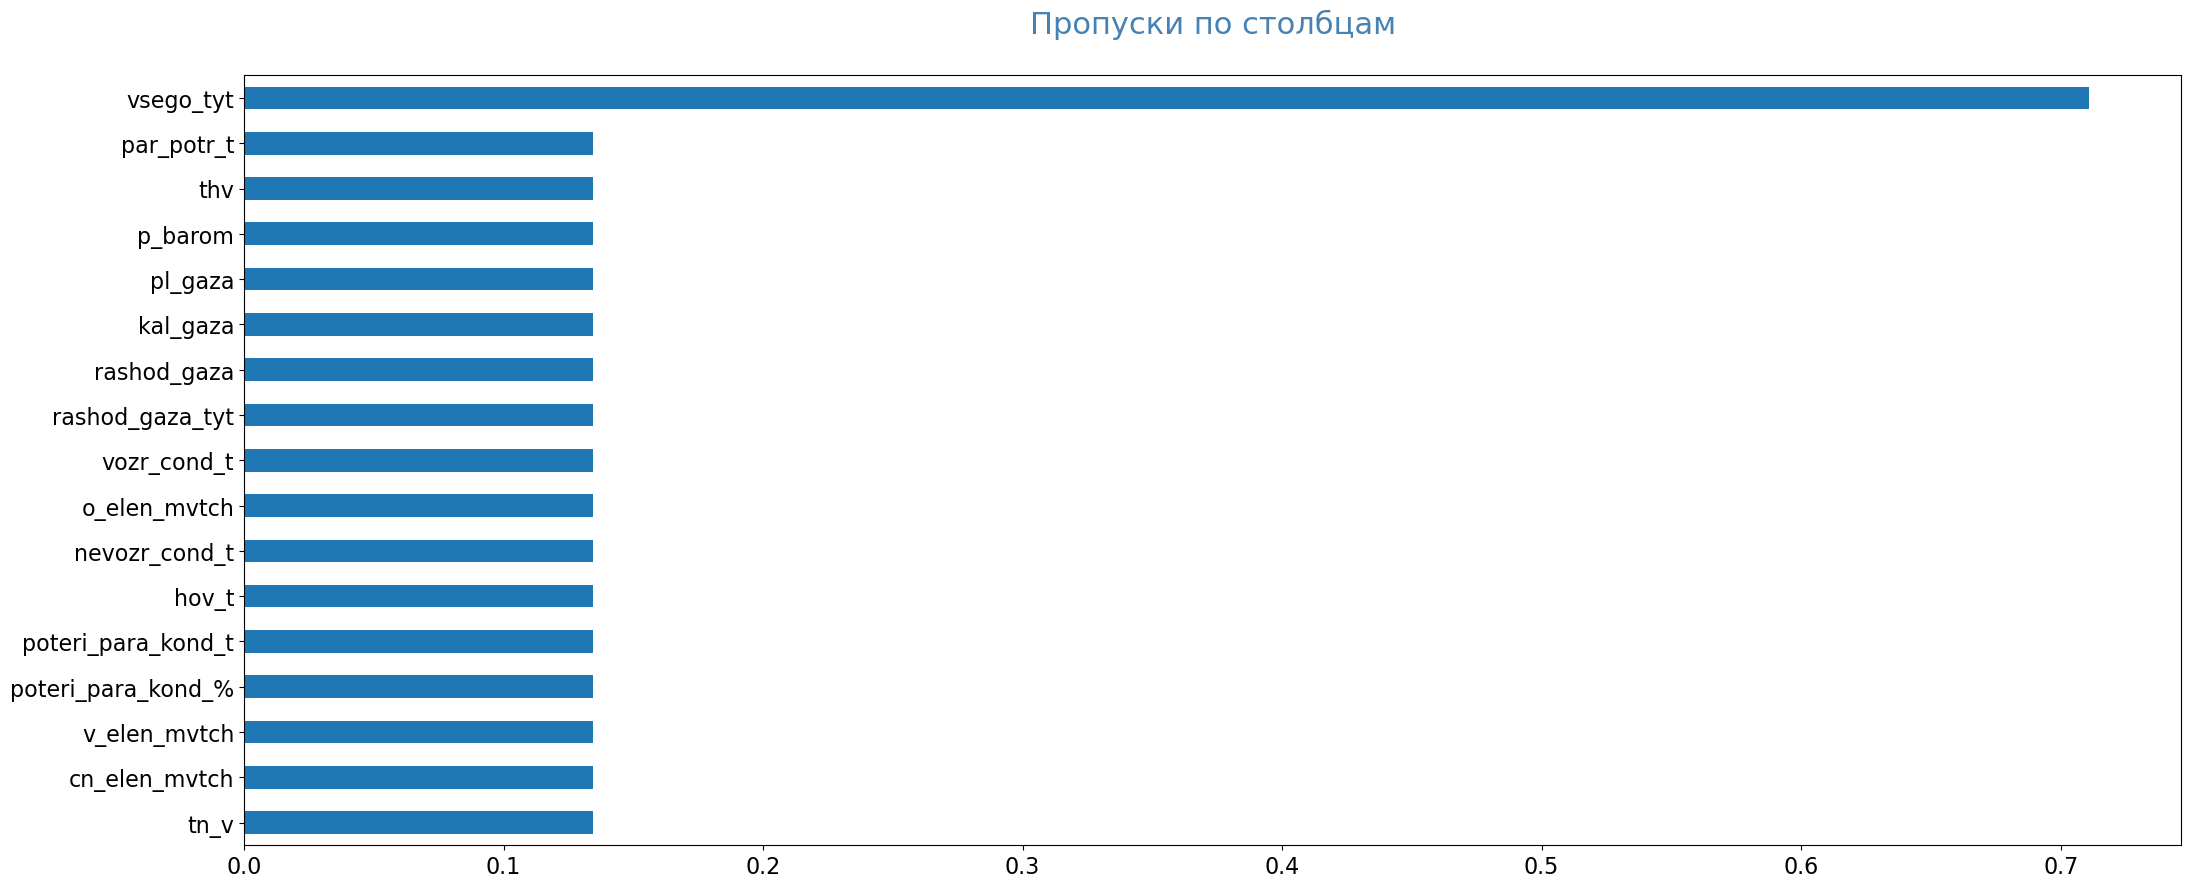

In [12]:
pass_value_barh(elen)

In [13]:
elen['vsego_tyt'] = elen['vsego_tyt'].fillna(elen['rashod_gaza_tyt'])

In [14]:
# Заполняем пропуски нулями
elen = elen.fillna(0)

### 1.3 Обьединение датасетов

In [15]:
# Обьединение датасетов 
df_merge = df.merge(elen, on='date', how='left' )

In [16]:
# убираем из датасета те дни когда не рабртала тэц
df_merge = df_merge[df_merge['rashod_gaza_tyt'] != 0]

In [17]:
df_merge_corr = df_merge[['date','v м1','v м2','v q','v t1','n м1','n м2',
                         'n q','n t1','tnv','th_v','steam t','steam q','sum_q',
                         'rashod_gaza','rashod_gaza_tyt','v_elen_mvtch','cn_elen_mvtch',
                          'o_elen_mvtch','vsego_tyt']]

### 1.4 Определяем выбросы 

In [18]:
# функция которая убирает выбросы 
def detect_outliers(df):
    outliers_bounds = {}
    for column in df.columns:
        if df[column].dtype != object:  # Игнорируем нечисловые столбцы
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers_bounds[column] = (lower_bound, upper_bound)
    return outliers_bounds

# Функция для фильтрации выбросов
def filter_outliers(df, outliers_bounds):
    filtered_df = df.copy()
    for column, bounds in outliers_bounds.items():
        lower_bound, upper_bound = bounds
        filtered_df = filtered_df[(filtered_df[column] >= lower_bound) & (filtered_df[column] <= upper_bound)]
    return filtered_df

In [19]:
# Находим границы выбросов
outliers = detect_outliers(df_merge_corr)

# Фильтрация DataFrame на основе границ выбросов
filtered_df = filter_outliers(df_merge_corr, outliers)

# Выводим количество строк до и после фильтрации
print("Number of rows before filtering:", len(df_merge_corr))
print("Number of rows after filtering:", len(filtered_df))


Number of rows before filtering: 4879
Number of rows after filtering: 4460


## 	2 Визуализация данных

### 2.1. Корреляция

Давайте создадим таблицу корреляции параметров для выбора наиболее подходящих переменных для построения моделей прогнозирования. 

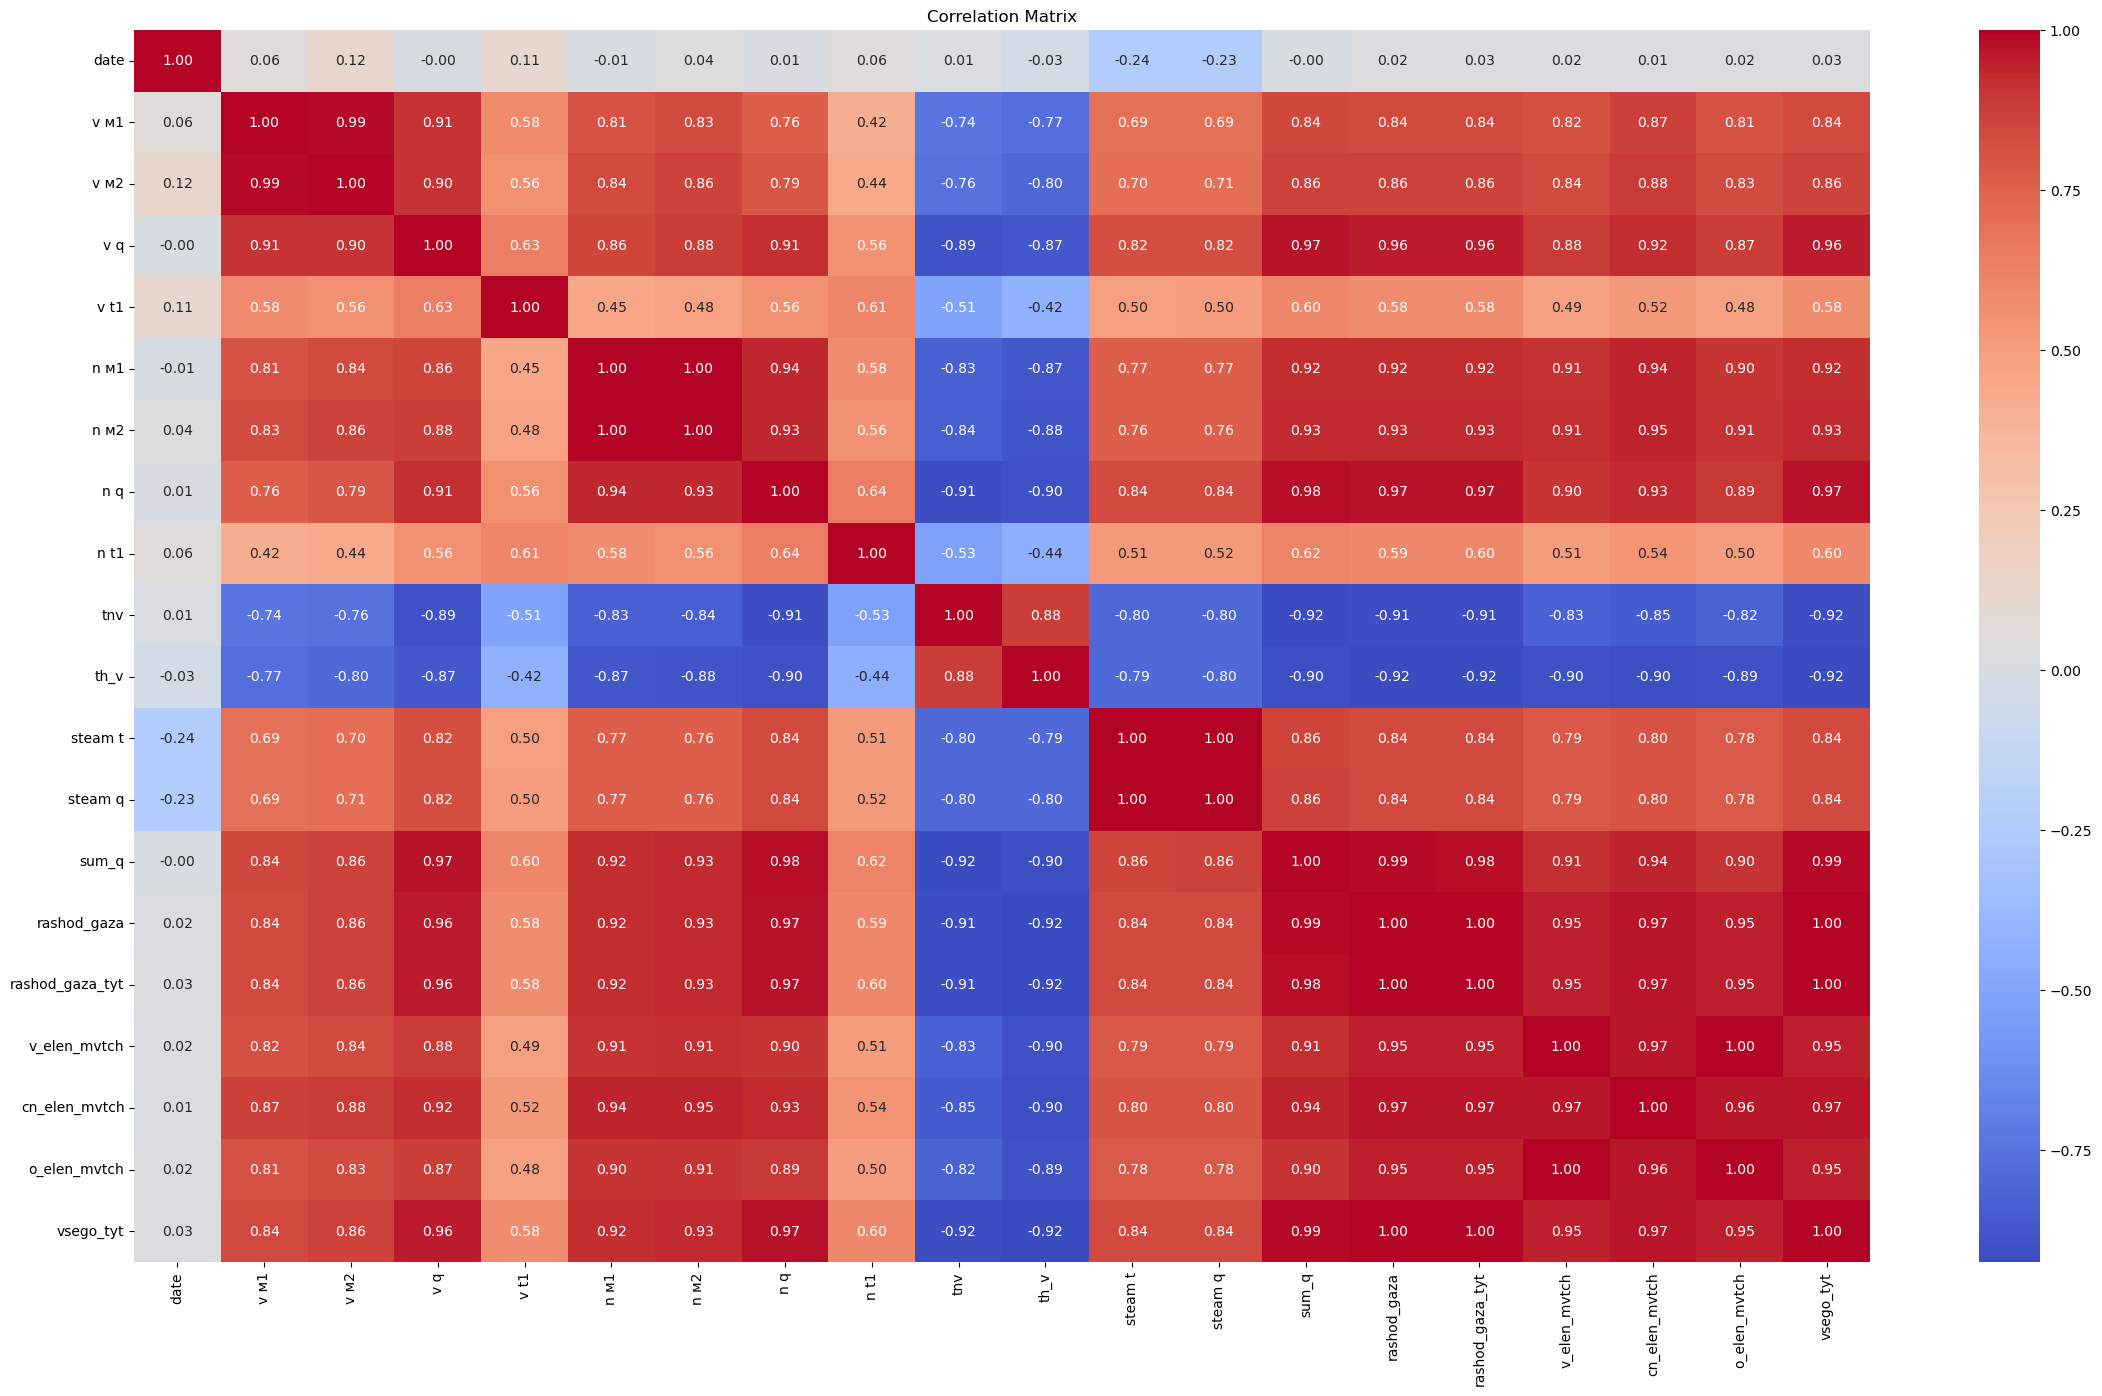

In [20]:
correlation_matrix_merge = df_merge_corr.corr()
plt.figure(figsize=(28, 16))
sns.heatmap(correlation_matrix_merge, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

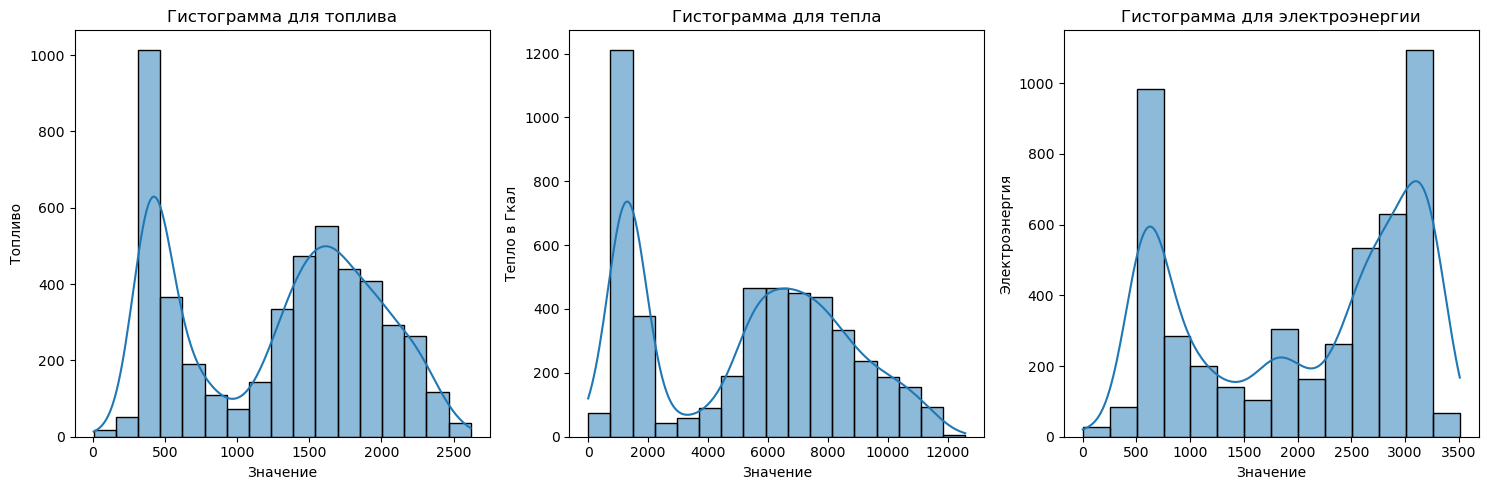

In [21]:
# Создаем график с тремя подграфиками
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Построение первой гистограммы
sns.histplot(df_merge_corr['vsego_tyt'], kde=True, palette='rainbow', label='Топливо', ax=axes[0])
axes[0].set_xlabel('Значение')
axes[0].set_ylabel('Топливо')
axes[0].set_title('Гистограмма для топлива')

# Построение второй гистограммы
sns.histplot(df_merge_corr['sum_q'], kde=True, palette='rainbow', label='Тепло в Гкал', ax=axes[1])
axes[1].set_xlabel('Значение')
axes[1].set_ylabel('Тепло в Гкал')
axes[1].set_title('Гистограмма для тепла')

# Построение третьей гистограммы
sns.histplot(df_merge_corr['v_elen_mvtch'], kde=True, palette='rainbow', label='Электроэнергия', ax=axes[2])
axes[2].set_xlabel('Значение')
axes[2].set_ylabel('Электроэнергия')
axes[2].set_title('Гистограмма для электроэнергии')

# Регулируем расстояние между графиками
plt.tight_layout()

# Показываем графики
plt.show()

Из графика видно, что наблюдается выраженная асимметрия влево. Это объясняется двумя типами режимов работы ТЭЦ: в (ОЗП) и межотопительный период. Удаление данных не является вариантом, поскольку они охватывают значительный временной промежуток. Для того чтобы учесть оба режима работы, мы можем использовать дату при построении модели.

### 3 Построение прогнозирующей модели

При каждом этапе построения модели мы применяли несколько методов, однако в данной работе представлен лучший вариант.

### 3.1 Построить модель, прогнозирующую отпуск тепла через основные показатели тепла.

In [22]:
df_new = df_merge_corr[['date','sum_q','tnv','v м1','v м2','n м1','n м2','v t1','n t1']]

# Извлечение признаков из даты
df_new['year'] = df_new['date'].dt.year
df_new['month'] = df_new['date'].dt.month
df_new['day'] = df_new['date'].dt.day
df_new['weekday'] = df_new['date'].dt.weekday

In [23]:
# Выделение признаков и целевой переменной
X = df_new[['tnv','v м1','v м2','n м1','n м2','v t1','n t1', 'year', 'month', 'day', 'weekday']]
y = df_new['sum_q']

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Определение пространства поиска гиперпараметров
space = {
    'iterations': hp.choice('iterations', [500, 1000, 1500]),
    'depth': hp.choice('depth', [4, 6, 8]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10)
}

# Определение функции оценки
def evaluate(params):
    model = CatBoostRegressor(**params)
    model.fit(X_train, y_train, verbose=False)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Настройка параметров hyperopt
trials = Trials()
best = fmin(fn=evaluate,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

# Получение лучших гиперпараметров
best_params = space_eval(space, best)

# Обучение модели с лучшими гиперпараметрами
best_model_1 = CatBoostRegressor(verbose=False, **best_params)
best_model_1.fit(X_train, y_train)

# Прогнозирование значений на тестовом наборе
y_pred_best = best_model_1.predict(X_test)

# Оценка точности модели с лучшими гиперпараметрами
mse_best = mean_squared_error(y_test, y_pred_best)
print("Best CatBoostRegressor Mean Squared Error:", mse_best)


100%|███████| 100/100 [03:39<00:00,  2.19s/trial, best loss: 16576.223027847827]
Best CatBoostRegressor Mean Squared Error: 16576.223027847827


In [25]:
# Посчитать коэффициент детерминации для тестовых данных
r2_score = best_model_1.score(X_test, y_test)
print("R^2 score:", r2_score)

R^2 score: 0.9984952177748081


In [26]:
def forecast_calculation_1(model, new_th_v, new_tnv, new_v_m1, new_v_m2, new_n_m1, new_n_m2, new_v_t1,new_n_t1, date):
    result= [[new_th_v, new_tnv, new_v_m1, new_v_m2, new_n_m1, new_n_m2, new_v_t1,new_n_t1,\
            date.year, date.month, date.day, date.weekday()]]
    predicted = model.predict(result)
    print("Predicted sum_q:", predicted)
    

In [27]:
forecast_calculation_1(best_model_1, 2.48, 10.7, 93067, 84598,116507,107853,71.10,71.07, pd.Timestamp('2024-04-10'))

Predicted sum_q: [5289.05885686]


In [28]:
forecast_calculation_1(best_model_1, 4.53, 5.7, 95690, 87167,116679,108911,71.92,71.88, pd.Timestamp('2024-04-15'))

Predicted sum_q: [5205.69597848]


In [29]:
forecast_calculation_1(best_model_1, 4.32, 9.1, 92673, 84113,115252,106395,72.52,72.48, pd.Timestamp('2024-04-14'))

Predicted sum_q: [5201.82439101]


### 3.2 Построить модель, прогнозирующую отпуск тепла по общим характеристикам ТЭЦ.

In [30]:

# Извлечение признаков из даты
df_merge_corr['year'] = df_merge_corr['date'].dt.year
df_merge_corr['month'] = df_merge_corr['date'].dt.month
df_merge_corr['day'] = df_merge_corr['date'].dt.day
df_merge_corr['weekday'] = df_merge_corr['date'].dt.weekday

In [31]:
# Выделение признаков и целевой переменной
X_1 = df_merge_corr[['tnv','rashod_gaza_tyt','v t1','v_elen_mvtch','year', 'month', 'day', 'weekday']]
y_1 = df_merge_corr['sum_q']

# Разделение данных на обучающий и тестовый наборы
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=42)


In [32]:
# Определение пространства поиска гиперпараметров
space = {
    'iterations': hp.choice('iterations', [500, 1000, 1500]),
    'depth': hp.choice('depth', [4, 6, 8]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10)
}
# Определение функции оценки
def evaluate(params):
    model = CatBoostRegressor(**params)
    model.fit(X_train_1, y_train_1, verbose=False)
    y_pred_1 = model.predict(X_test_1)
    mse = mean_squared_error(y_test_1, y_pred_1)
    return mse

# Настройка параметров hyperopt
trials = Trials()
best = fmin(fn=evaluate,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

# Получение лучших гиперпараметров
best_params = space_eval(space, best)

# Обучение модели с лучшими гиперпараметрами
best_model_1 = CatBoostRegressor(verbose=False, **best_params)
best_model_1.fit(X_train_1, y_train_1)

# Прогнозирование значений на тестовом наборе
y_pred_best = best_model_1.predict(X_test_1)

# Оценка точности модели с лучшими гиперпараметрами
mse_best = mean_squared_error(y_test_1, y_pred_best)
print("Best CatBoostRegressor Mean Squared Error:", mse_best)

100%|███████| 100/100 [03:14<00:00,  1.95s/trial, best loss: 31887.876646264223]
Best CatBoostRegressor Mean Squared Error: 31887.876646264223


In [33]:
# Посчитать коэффициент детерминации для тестовых данных
r2_score = best_model_1.score(X_test_1, y_test_1)
print("R^2 score: {:.2f}%".format(r2_score * 100))

R^2 score: 99.71%


In [34]:
def forecast_calculation(model, new_tnv, new_rashod_gaza_tyt, new_v_elen_mvtch, date):
    # Extract weekday from the date
    weekday = date.weekday()
    
    # Create the input data including the weekday feature
    result = [[new_tnv, new_rashod_gaza_tyt, new_v_elen_mvtch,
               date.year, date.month, date.day, weekday]]
    
    # Predict using the model
    predicted = model.predict(result)
    
    # Print the predicted value
    print("Predicted sum_q:", predicted)

In [35]:
# Example usage
# forecast_calculation(best_model, -1.8, 1891.6, 3200.33, pd.Timestamp('2024-04-05'))

### 3.3 Построить модель, прогнозирующую расход газа относительно выработки электроэнергии и тепла.


In [36]:
df_tyt = df_merge[['date','vsego_tyt','v_elen_mvtch','cn_elen_mvtch','thv','tn_v','sum_q','v t1']]

# Извлечение признаков из даты
df_tyt['year'] = df_tyt['date'].dt.year
df_tyt['month'] = df_tyt['date'].dt.month
df_tyt['day'] = df_tyt['date'].dt.day
df_tyt['weekday'] = df_tyt['date'].dt.weekday

# Выделение признаков и целевой переменной
X_2 = df_tyt[['date','v_elen_mvtch','sum_q', 'year', 'month', 'day', 'weekday']]
y_2 = df_tyt['vsego_tyt']

# Разделение данных на обучающий и тестовый наборы
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

In [37]:

# Определение пространства поиска гиперпараметров
space = {
    'iterations': hp.choice('iterations', [500, 1000, 1500]),
    'depth': hp.choice('depth', [4, 6, 8]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10)
}

# Определение функции оценки
def evaluate(params):
    model = CatBoostRegressor(**params)
    model.fit(X_train_2, y_train_2, verbose=False)
    y_pred_2 = model.predict(X_test_2)
    mse = mean_squared_error(y_test_2, y_pred_2)
    return mse

# Настройка параметров hyperopt
trials = Trials()
best = fmin(fn=evaluate,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

# Получение лучших гиперпараметров
best_params = space_eval(space, best)

# Обучение модели с лучшими гиперпараметрами
best_model_2 = CatBoostRegressor(verbose=False, **best_params)
best_model_2.fit(X_train_2, y_train_2)

# Прогнозирование значений на тестовом наборе
y_pred_best = best_model_2.predict(X_test_2)

# Оценка точности модели с лучшими гиперпараметрами
mse_best = mean_squared_error(y_test_2, y_pred_best)
print("Best CatBoostRegressor Mean Squared Error:", mse_best)


100%|████████| 100/100 [02:59<00:00,  1.79s/trial, best loss: 909.7166741016526]
Best CatBoostRegressor Mean Squared Error: 909.7166741016526


In [38]:
# Посчитать коэффициент детерминации для тестовых данных
r2_score = best_model_2.score(X_test_2, y_test_2)
print("R^2 score: {:.2f} %".format(r2_score * 100))

R^2 score: 99.80 %


In [70]:

# Пример создания DataFrame с новыми данными
data_new = {
    'date': ['2024-04-21', '2024-04-22'],  # Пример даты, замените на реальные даты
    'v_elen_mvtch': [10, 15],  # Пример значений v_elen_mvtch
    'sum_q': [100, 150],  # Пример значений sum_q
}

df_new = pd.DataFrame(data_new)

# Извлечение признаков из даты
df_new['date'] = pd.to_datetime(df_new['date'])
df_new['year'] = df_new['date'].dt.year
df_new['month'] = df_new['date'].dt.month
df_new['day'] = df_new['date'].dt.day
df_new['weekday'] = df_new['date'].dt.weekday

# Теперь df_new готов для использования в предсказаниях
# Предсказание значений с использованием обученной модели
y_pred_new = best_model_2.predict(df_new[['date', 'v_elen_mvtch', 'sum_q', 'year', 'month', 'day', 'weekday']])

# В y_pred_new будут содержаться предсказанные значения для новых данных
y_pred_new

array([326.51018486, 245.15428304])

### 3.4 Построить модель, прогнозирующую расход тепла относительно выработки электроэнергии и расхода газа.

In [39]:
# Выделение признаков и целевой переменной
X_3 = df_tyt[['date','vsego_tyt','sum_q', 'year', 'month', 'day', 'weekday']]
y_3 = df_tyt['v_elen_mvtch']

# Разделение данных на обучающий и тестовый наборы
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=42)

In [40]:


# Определение пространства поиска гиперпараметров
space = {
    'iterations': hp.choice('iterations', [500, 1000, 1500]),
    'depth': hp.choice('depth', [4, 6, 8]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10)
}

# Определение функции оценки
def evaluate(params):
    model = CatBoostRegressor(**params)
    model.fit(X_train_3, y_train_3, verbose=False)
    y_pred_3 = model.predict(X_test_3)
    mse = mean_squared_error(y_test_3, y_pred_3)
    return mse

# Настройка параметров hyperopt
trials = Trials()
best = fmin(fn=evaluate,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

# Получение лучших гиперпараметров
best_params = space_eval(space, best)

# Обучение модели с лучшими гиперпараметрами
best_model_3 = CatBoostRegressor(verbose=False, **best_params)
best_model_3.fit(X_train_3, y_train_3)

# Прогнозирование значений на тестовом наборе
y_pred_best_3 = best_model_3.predict(X_test_3)

# Оценка точности модели с лучшими гиперпараметрами
mse_best = mean_squared_error(y_test_3, y_pred_best_3)
print("Best CatBoostRegressor Mean Squared Error:", mse_best)

100%|████████| 100/100 [03:19<00:00,  1.99s/trial, best loss: 7208.148046286155]
Best CatBoostRegressor Mean Squared Error: 7208.148046286155


In [41]:
# Посчитать коэффициент детерминации для тестовых данных
r2_score = best_model_3.score(X_test_3, y_test_3)
print("R^2 score: {:.2f} %".format(r2_score * 100))

R^2 score: 99.35 %


### 3.5 Построить модель, прогнозирующую выработку электроэнергии относительно расхода тепла и расхода газа.


In [42]:
# Выделение признаков и целевой переменной
X_4 = df_tyt[['date','vsego_tyt','v_elen_mvtch', 'year', 'month', 'day', 'weekday']]
y_4 = df_tyt['sum_q']

# Разделение данных на обучающий и тестовый наборы
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_4, y_4, test_size=0.2, random_state=42)

In [43]:


# Определение пространства поиска гиперпараметров
space = {
    'iterations': hp.choice('iterations', [500, 1000, 1500]),
    'depth': hp.choice('depth', [4, 6, 8]),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10)
}

# Определение функции оценки
def evaluate(params):
    model = CatBoostRegressor(**params)
    model.fit(X_train_4, y_train_4, verbose=False)
    y_pred_4 = model.predict(X_test_4)
    mse = mean_squared_error(y_test_4, y_pred_4)
    return mse

# Настройка параметров hyperopt
trials = Trials()
best = fmin(fn=evaluate,
            space=space,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

# Получение лучших гиперпараметров
best_params = space_eval(space, best)

# Обучение модели с лучшими гиперпараметрами
best_model_4 = CatBoostRegressor(verbose=False, **best_params)
best_model_4.fit(X_train_4, y_train_4)

# Прогнозирование значений на тестовом наборе
y_pred_best = best_model_4.predict(X_test_4)

# Оценка точности модели с лучшими гиперпараметрами
mse_best = mean_squared_error(y_test_4, y_pred_best)
print("Best CatBoostRegressor Mean Squared Error:", mse_best)

100%|█████████| 100/100 [02:14<00:00,  1.34s/trial, best loss: 41202.9001144627]
Best CatBoostRegressor Mean Squared Error: 41202.9001144627


In [44]:
# Посчитать коэффициент детерминации для тестовых данных
r2_score = best_model_4.score(X_test_4, y_test_4)
print("R^2 score: {:.2f} %".format(r2_score * 100))

R^2 score: 99.63 %


## Выводы

to be continue